In [7]:
# Let us first load all the packages :
import numpy as np
import cv2
from math import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#%matplotlib inline
from matplotlib import pyplot as plt

# Now let us define the helper functions :

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color = [255, 0, 0])
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha =0.8, beta =1., lamb =0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lamb)

In [54]:
# Now let us write a function process_image_broken
# This function draws the broken / segmented lines onto an input color image
def process_image_broken(image):
    
    # Convert the image to grayscale and display it
    gray = grayscale(image)        
    plt.imshow(gray, cmap = 'gray'), plt.title("Grayscale"), plt.show()
    
    # Use gaussian_blur function to remove some noise and display the blurred image
    blurred = gaussian_blur(gray, 7)        
    plt.imshow(blurred, cmap = 'gray'), plt.title("Blurred Image"), plt.show()
    
    # Use canny function to get edge image and display it
    edged = canny(blurred, 50, 150)        
    plt.imshow(edged, cmap = 'gray'), plt.title("Edges in Blurred Image"), plt.show()
    
    # Define vertices for the region of interest
    vertices = np.array( [[[150, image.shape[0]],[455, 315],[510 , 315],[900, image.shape[0]]]], dtype=np.int32 )
    # Get masked image using region_of_interest function, display it
    masked_image = region_of_interest(edged, vertices)        
    plt.imshow(masked_image, cmap = 'gray'), plt.title("Masked image containing region of interest"), plt.show()
    
    # Define parameters for houghlines function
    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_length = 1
    max_line_gap = 20
    # Get the lines using cv2.HoughLinesP function and draw the lines on the masked image using hough_lines
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]),
                              min_line_length, max_line_gap)
    line_image= hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
     
    # Display line_image    
    plt.imshow(line_image, cmap = 'gray'), plt.title("Masked region with segmented lines"),plt.show()
    
    # Now let us draw the segmented / broken lines on the image using weighted fucntion
    segment_image = weighted_img(line_image, image, alpha = 0.7, beta = 0.3, lamb = 50)
    plt.imshow(segment_image, cmap = 'gray'), plt.title("Segmented Image"), plt.show()
    
    return segment_image
    

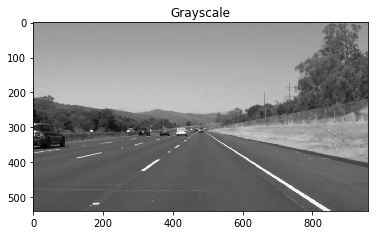

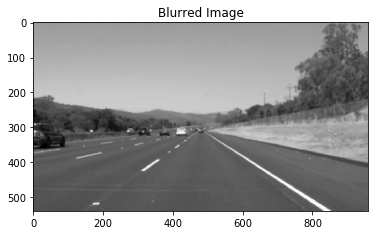

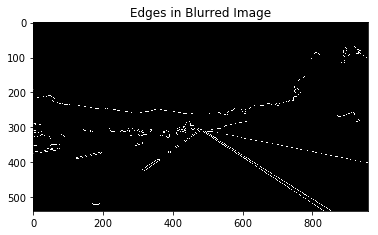

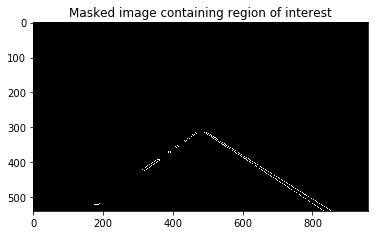

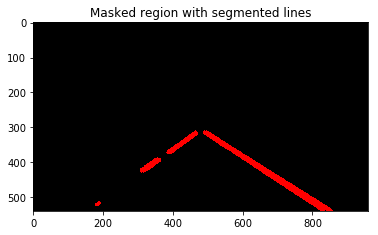

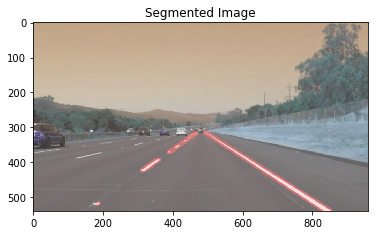

In [55]:
import cv2
image = cv2.imread('C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight.jpg')
out = process_image_broken(image)

In [52]:
# Now let us write a function process_image_cont
# This function draws the extrapolated/continuous lines onto an input color image
def process_image_cont(image):
    
    # Convert the image to grayscale and display it
    gray = grayscale(image)
#     plt.imshow(gray, cmap = 'gray'), plt.title("Grayscale"), plt.show()
    
    # Use gaussian_blur function to remove some noise and display the blurred image
    blurred = gaussian_blur(gray, 11)
#     plt.imshow(blurred, cmap = 'gray'), plt.title("Blurred Image"), plt.show()
    
    # Use canny function to get edge image and display it
    edged = canny(blurred, 50, 150)
#     plt.imshow(edged, cmap = 'gray'), plt.title("Edges in Blurred Image"), plt.show()
    
    # Define vertices for the region of interest
    vertices = np.array( [[[150, image.shape[0]],[420, 330],[500 , 320],[900, image.shape[0]]]], dtype=np.int32 )
    # Get masked image using region_of_interest function, display it
    masked_image = region_of_interest(edged, vertices)
#     plt.imshow(masked_image, cmap = 'gray'), plt.title("Masked image containing region of interest"), plt.show()
    
    # Define parameters for houghlines function
    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_length = 1
    max_line_gap = 20
    # Get the lines using cv2.HoughLinesP function and draw the lines on the masked image using hough_lines
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]),
                              min_line_length, max_line_gap)
    line_image= hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Display line_image
#     plt.imshow(line_image, cmap = 'gray'), plt.title("Masked region with segmented lines"),plt.show()
    
    # Now let us draw the segmented / broken lines on the image using weighted fucntion
    segment_image = weighted_img(line_image, image, alpha = 0.7, beta = 0.3)
    #plt.imshow(segment_image, cmap = 'gray'), plt.title("Segmented Image"), plt.show()
    # Let us define lists for storing the left and right co-ordinates as well as slopes
    thetaleft = []
    thetaright = []
    xleft = []
    yleft = []
    xright = []
    yright = []
    # Define a threshold for slopes of the lanes
    slopethresh = 0.5
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Calculate the slope
            theta = atan2( (y2 - y1), (x2- x1))
            #print theta
            if abs(theta) > slopethresh:
                # If the slope is negative we can predict it is a left lane and store the slope
                if theta < 0:
                    thetaleft.append(theta)
                    # If the x co-ordinate is too far to the right, threshold it
                    if x1 > (image.shape[1]/2):
                        x1 = int(image.shape[1]/2)
                    if x2 > (image.shape[1]/2):
                        x2 = int(image.shape[1]/2)
                    xleft.append(x1)
                    xleft.append(x2)
                    yleft.append(y1)
                    yleft.append(y2)
                else:                    
                    thetaright.append(theta)
                    xright.append(x1)
                    xright.append(x2)
                    yright.append(y1)
                    yright.append(y2)
    # Convert the lists of x and y co-ordinates to array
    xleft = np.asarray(xleft)
    yleft = np.asarray(yleft)
    xright = np.asarray(xright)
    yright = np.asarray(yright)
    # Fit the left and right line using polyfit function to get the slope and intercept of the lines
    paraleft = np.polyfit(xleft, yleft, 1)
    pararight = np.polyfit(xright, yright, 1)
    # Use poly1d to get the function y = f(x) to evaluate y at any x-coordinate
    fleft = np.poly1d(paraleft)
    fright = np.poly1d(pararight)
    # We can define the max y co-ordinate of left lane as height of image and use slope and intercept of 
    # left line to retrieve the corresponding x co-ordinate.
    yleftmax = image.shape[0]
    xleftmin = int( (yleftmax - paraleft[1]) / paraleft[0] )    
    # Do the same for right lane
    yrightmax = image.shape[0]
    xrightmax = int( (yrightmax - pararight[1]) / pararight[0])
    # The value of min(xright) is rather fluctuating, so we define a value based on the set of min(xright) values
    # to minimize the deviation of the right lane and define our xrightmin value as below
    xrightmin = 505
    #xrightmin = min(xright)
    # Finally draw the lines on the image        
    cv2.line(line_image,(xleftmin, yleftmax),(max(xleft), int(fleft(max(xleft)))),(255,0,0),20)
    cv2.line(line_image,(xrightmin, int(fright(xrightmin))),(xrightmax, yrightmax),(255,0,0),20)
    
    # Plot the line image if required
    plt.imshow(line_image, cmap = 'gray'), plt.show()#plt.plot(xrightmin, yrightmin, 'bo'), plt.show()
    # Return the weighted_img as the output of the function
    output = weighted_img(line_image, image, alpha = 0.7, beta = 0.3, lamb = 60)
    plt.imshow(output, cmap = 'gray'), plt.title("Output"), plt.show()
    
    return output
                
        
        

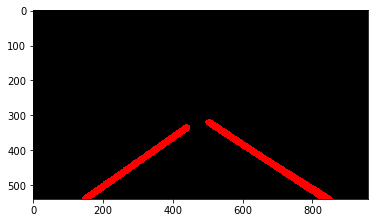

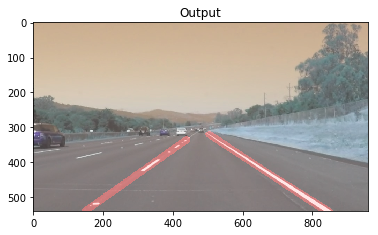

In [53]:
import time
image = cv2.imread('C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidWhiteRight.jpg')
output = process_image_cont(image)

In [42]:
import cv2
image = cv2.imread('C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
output = process_image_cont(image)
#define output video path
white_output = 'C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidWhiteRightOutput.mp4'
# Create instance of clip from the video in given path
clip1 = VideoFileClip("C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidWhiteRight.mp4")
# Process the video file and draw lines on it and save it in output folder
white_clip = clip1.fl_image(process_image_cont)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidWhiteRightOutput.mp4
[MoviePy] Writing video C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidWhiteRightOutput.mp4


100%|███████████████████████████████████████▊| 221/222 [00:05<00:00, 43.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidWhiteRightOutput.mp4 



In [138]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
 
""".format(white_output))

In [45]:
import cv2
image = cv2.imread('C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
output = process_image_cont(image)
#define output video path
yellow_output = 'C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidYellowLeftOutput.mp4'
# Create instance of clip from the video in given path
clip1 = VideoFileClip("C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidYellowLeft.mp4")
# Process the video file and draw lines on it and save it in output folder
yellow_clip = clip1.fl_image(process_image_cont)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidYellowLeftOutput.mp4
[MoviePy] Writing video C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidYellowLeftOutput.mp4


100%|███████████████████████████████████████▉| 681/682 [00:16<00:00, 40.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/lenovo/Documents/SDCND/CarND-LaneLines-P1-master/CarND-LaneLines-P1-master/test_videos/solidYellowLeftOutput.mp4 



In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
 
""".format(yellow_output))